In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import os

import helper_functions as helper

In [2]:
with open('data_path.txt', 'r') as f:
    data_path = os.path.join(f.readline(), 'steering')

file_path = os.path.join(data_path, 'MarkkulaEtAl_BiolCyb2018_DataWithIntermittentInterpretation.mat')
data = helper.loadmat(file_path)

sightpoint_filepath = os.path.join(data_path, 'PreCalculatedSightPointSignalData.mat')
sightpoint_data = helper.loadmat(sightpoint_filepath)['SSightPointPreCalc']

lk_data = data['STasks'][0]
lk_sightpoint_data = sightpoint_data.STasks[0]
lk_subjects = np.arange(1, 16)

cd_data = data['STasks'][1]
cd_sightpoint_data = sightpoint_data.STasks[1]
cd_subjects = np.arange(1, 9)

# Prepare passive phase data

In [69]:
def get_p(sightpoint_recording):
    p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
    
    # Is SSightPointPreviewTimes[0] the near one, and SSightPointPreviewTimes[1] the far one?
    near_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[0].SPathVariants.SSightPointSignals)
    nsp_angle = near_sightpoint.VSightPointAngle
    nsp_rate = near_sightpoint.VSightPointRate

    far_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[1].SPathVariants.SSightPointSignals)
    fsp_angle = far_sightpoint.VSightPointAngle
    fsp_rate = far_sightpoint.VSightPointRate
    
    p = p_weights['k_nI']*nsp_angle + p_weights['k_nP']*nsp_rate + p_weights['k_f']*fsp_rate
    
    return p

def get_passive_phase_data(data, sightpoint_data):
    passive_phases = []
    for i, driver in enumerate(data.SDrivers):
        for j, recording in enumerate(driver.SRecordings):
            # Option 1: steering wheel angular velocity from the original data
#             v = recording.SSignals.VSWRate

            # Option 2: VSWRate might be a bit oversmoothed, which might lead to underestimation of 
            # inter-adjustment intervals, so we try an alternative numerical differentiation algo here
            v = helper.differentiate(recording.SSignals.VTimeStamp, recording.SSignals.VSWAngle)
            
            # Also, here we'll try out a custom adjustment onset extraction algorithm I used for the stick data
            # It will miss adjustments initiated in the middle of preceding adjustment, but the thing
            # is, if we are to analyze inter-adjustment intervals, these are not well-defined here,
            # so I believe it's better to treat multi-movement corrections as a single adjustment
            starting_points, action_points = helper.extract_passive_phases(v)

            t_sp = recording.SSignals.VTimeStamp[starting_points]
            t_ap = recording.SSignals.VTimeStamp[action_points]
            
            p = get_p(sightpoint_data.SDrivers[i].SRecordings[j])

            df = pd.DataFrame({'subject': i+1,
                               'recording': j+1,
                               'passive_phase_number': np.arange(1, len(starting_points)+1),
                               'idx_sp': starting_points,
                               'idx_ap': action_points,
                               't_sp': t_sp, 
                               't_ap': t_ap,
                               'p_sp': abs(p[starting_points]),
                               'p_ap': abs(p[action_points])})
            
            passive_phases.append(df)
    
    passive_phases = pd.concat(passive_phases).set_index(['subject', 'recording'], drop=False)
    passive_phases['delta_t'] = passive_phases.t_ap - passive_phases.t_sp
    passive_phases['log_delta_t'] = np.log(passive_phases.delta_t)   
    passive_phases['log_p_sp'] = np.log(passive_phases.p_sp)
    passive_phases['p_sp_decile'] = pd.qcut(passive_phases['p_sp'], 10, labels=np.arange(1,11))
    return passive_phases

def save_passive_phases_to_csv(data, sightpoint_data, task):
    passive_phases = get_passive_phase_data(data, sightpoint_data)
    passive_phases.to_csv(os.path.join(data_path, 'passive_phases_%s.csv' % (task)), index=False)

In [70]:
save_passive_phases_to_csv(lk_data, lk_sightpoint_data, 'lk')
save_passive_phases_to_csv(cd_data, cd_sightpoint_data, 'cd')

# Check passive phase data

In [71]:
passive_phases_lk = pd.read_csv(os.path.join(data_path, 'passive_phases_lk.csv'), index_col=None)
passive_phases_cd = pd.read_csv(os.path.join(data_path, 'passive_phases_cd.csv'), index_col=None)

# there is an outlier in the circular driving task, better exclude it
print(passive_phases_cd[passive_phases_cd.p_sp>2])
passive_phases_cd = passive_phases_cd[passive_phases_cd.p_sp<2]

     subject  recording  passive_phase_number  idx_sp  idx_ap        t_sp  \
553        8          2                     8     455     467  201.333333   

           t_ap       p_sp     p_ap  delta_t  log_delta_t  log_p_sp  \
553  201.533333  23.669745  6.72356      0.2    -1.609438  3.164198   

     p_sp_decile  
553           10  


In [72]:
print(len(passive_phases_lk), len(passive_phases_cd))

2276 591


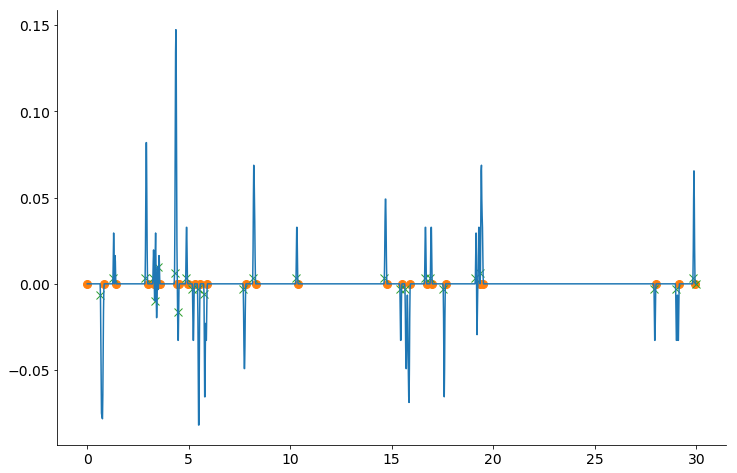

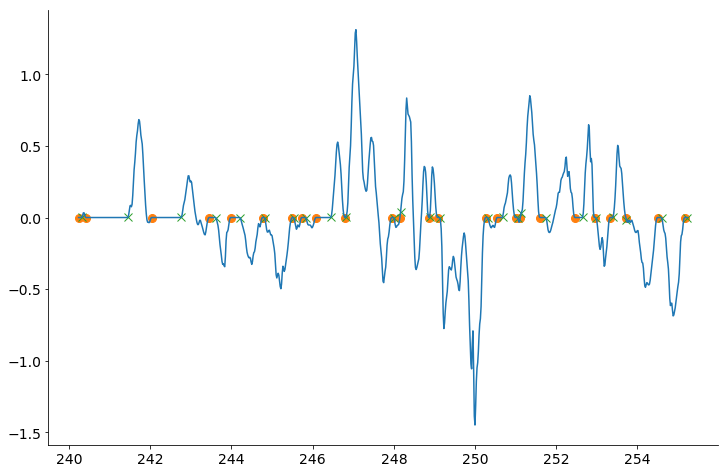

In [7]:
def plot_example_sw_rate(drivers, passive_phases, subject=1, recording=1):
    data = drivers.SDrivers[subject-1].SRecordings[recording-1]
    t = data.SSignals.VTimeStamp
    x = data.SSignals.VSWAngle
    v = helper.differentiate(t, x)

    ap_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_ap.values
    sp_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_sp.values

    fig, ax = plt.subplots(figsize=(12,8))    
    ax.plot(t[sp_idx], v[sp_idx], ls='', marker='o', ms=8, color='C1')
    ax.plot(t[ap_idx], v[ap_idx], ls='', marker='x', ms=8, color='C2')
    ax.plot(t, v)
#     ax.set_xlim([0,5])
    
plot_example_sw_rate(lk_data, passive_phases_lk, subject=1, recording=2)
plot_example_sw_rate(cd_data, passive_phases_cd, subject=1, recording=2)

# Exploring $\Delta_t$ distributions

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


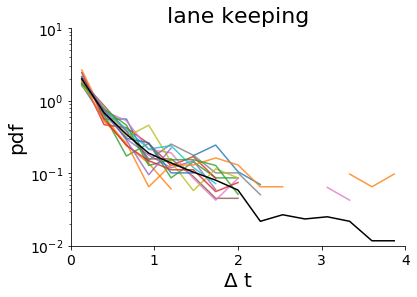

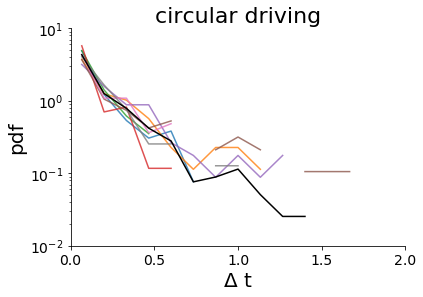

In [8]:
def plot_delta_t_hist(data, task, xlim):
    ax = helper.plot_pdf(data=data, var='delta_t', bins=np.linspace(0, xlim[1], 16))
#     ax = helper.plot_pdf(data=data, var='delta_t', bins=25)
    ax.set_xlabel('$\Delta$ t')
#     ax.set_ylabel('pdf')
    ax.set_xlim(xlim)
    ax.set_ylim((0.01, 10))
    ax.set_title(task)
    
    return ax
    
ax = plot_delta_t_hist(passive_phases_lk, 'lane keeping', (0., 4))
plt.savefig('figures/delta_t_pdf_lk.png')

ax = plot_delta_t_hist(passive_phases_cd, 'circular driving', (0., 2))
plt.savefig('figures/delta_t_pdf_cd.png')

# $p_{AP}$ distributions

(0.05, 50)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


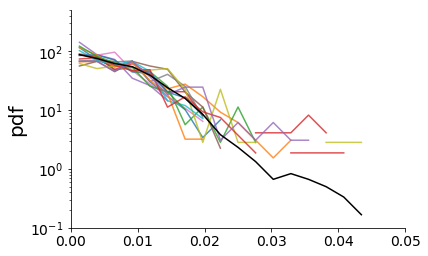

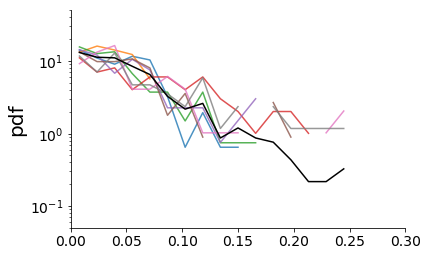

In [9]:
ax = helper.plot_pdf(data=passive_phases_lk, var='p_ap', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

ax = helper.plot_pdf(data=passive_phases_cd, var='p_ap', bins=np.linspace(0, 0.3, 20))
ax.set_xlim((0.0, 0.3))
ax.set_ylim((0.05, 50))

# $p_{SP}$ distributions

(0.05, 50)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


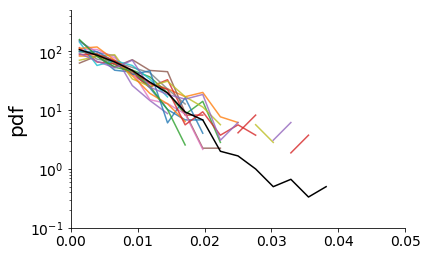

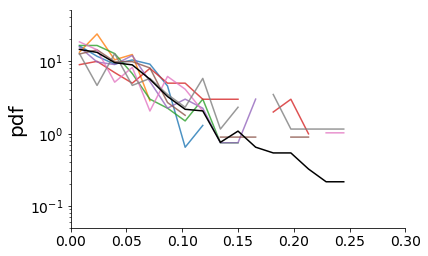

In [20]:
ax = helper.plot_pdf(data=passive_phases_lk, var='p_sp', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

ax = helper.plot_pdf(data=passive_phases_cd, var='p_sp', bins=np.linspace(0, 0.3, 20))
ax.set_xlim((0.0, 0.3))
ax.set_ylim((0.05, 50))

# Joint $p_{SP}$ vs $\Delta_t$ distributions

Assuming $p_{SP}$ is driving the decision to start steering, how does the adjustment initiation time change with $p_{SP}$?

In the lane keeping task, $\Delta_t$ generally decreases with $p_{SP}$

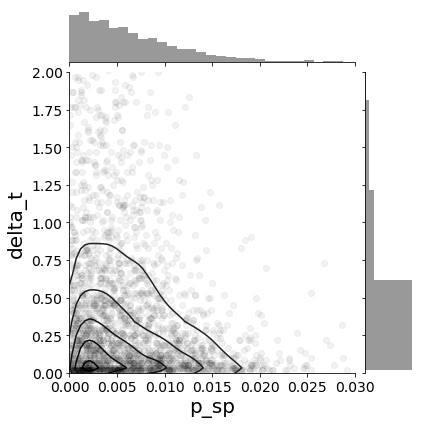

In [11]:
(sns.jointplot(x=passive_phases_lk.p_sp, y=passive_phases_lk.delta_t, alpha=0.05, xlim=(0, 0.03), ylim=(0, 2), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

However, in the circular driving task, $\Delta_t$ looks more-less constant

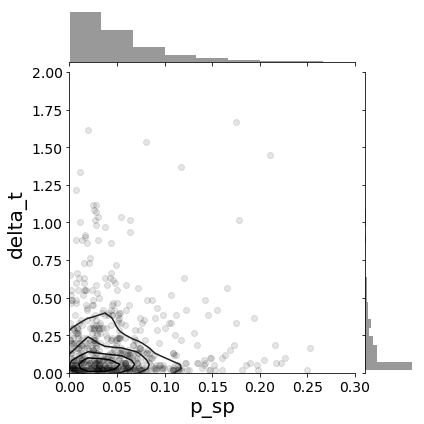

In [30]:
(sns.jointplot(x=passive_phases_cd.p_sp, y=passive_phases_cd.delta_t, alpha=0.1, xlim=(0, 0.3), ylim=(0, 2), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

To make this clearer, we'll plot average $\Delta_t$ for every decile of $p_{SP}$.

In the lane keeping task, $\Delta_t$ decreases from about 700-800ms for the least pressing situations to about 200ms for situations where the $p_{SP}$ is very large already in the beginning of a passive phase.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


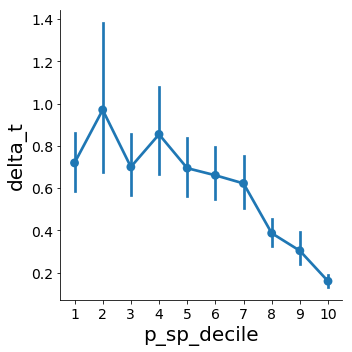

In [31]:
sns.factorplot(data=passive_phases_lk, x='p_sp_decile', y='delta_t', kind='point')

In contast, in the circular driving task, $\Delta_t$ doesn't really change much with $p_{SP}$, fluctuating around 200ms

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


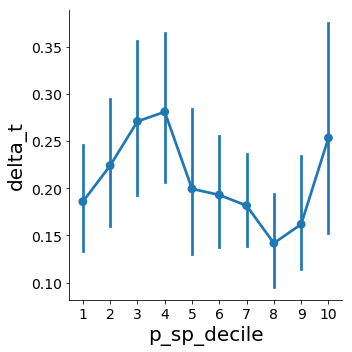

In [32]:
sns.factorplot(data=passive_phases_cd, x='p_sp_decile', y='delta_t', kind='point')

# Try looking at log-scaled $\Delta_t$ and $p_{SP}$?

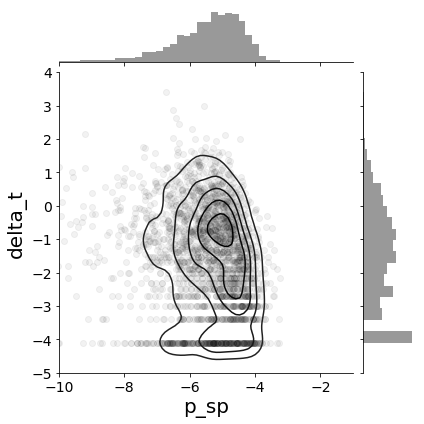

In [38]:
(sns.jointplot(x=np.log(passive_phases_lk[passive_phases_lk.p_sp>0].p_sp), 
               y=np.log(passive_phases_lk[passive_phases_lk.p_sp>0].delta_t), 
               xlim=(-10, -1), ylim=(-5, 4),
               alpha=0.05, color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

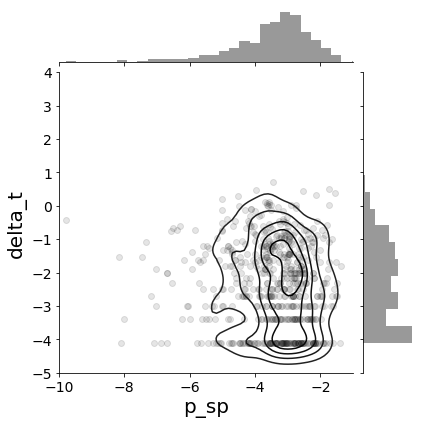

In [37]:
(sns.jointplot(x=np.log(passive_phases_cd[passive_phases_cd.p_sp>0].p_sp), 
               y=np.log(passive_phases_cd[passive_phases_cd.p_sp>0].delta_t), 
               xlim=(-10, -1), ylim=(-5, 4),
               alpha=0.1, color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


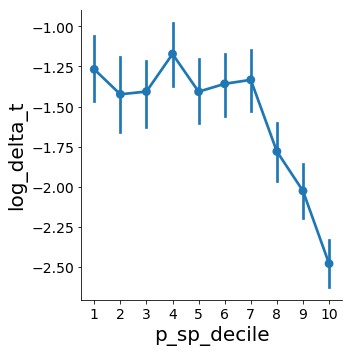

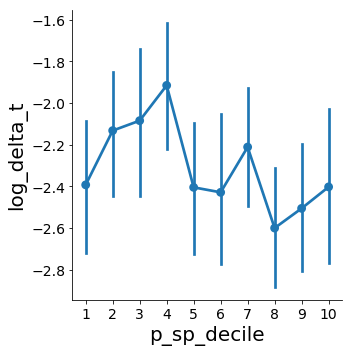

In [39]:
sns.factorplot(data=passive_phases_lk, x='p_sp_decile', y='log_delta_t', kind='point')
sns.factorplot(data=passive_phases_cd, x='p_sp_decile', y='log_delta_t', kind='point')

# Dynamics of $p_{sp}$ in the passive phase 

In [98]:
def get_p_dynamics(passive_phase):
    subject, recording = passive_phase.name[0]-1, passive_phase.name[1]-1
    p = get_p(lk_sightpoint_data.SDrivers[subject].SRecordings[recording])
    
    return pd.Series(p[int(passive_phase.idx_sp):int(passive_phase.idx_ap)])
    
p_dynamics = passive_phases_lk.groupby(['subject', 'recording', 'passive_phase_number']).apply(get_p_dynamics)

(0, 100)

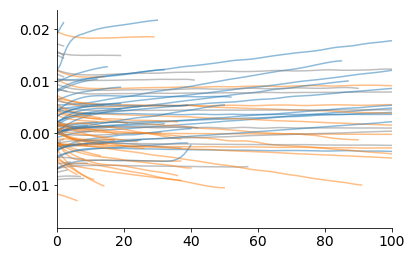

In [115]:
def plot_p(p_dynamics):
    threshold = 0.001
    if (p_dynamics[0] - p_dynamics[-1] < -threshold):
        color='C0'
    elif(p_dynamics[0] - p_dynamics[-1] > threshold):
        color='C1'
    else:
        color='grey'
            
    plt.plot(p_dynamics.values, color=color, alpha=0.5)
    
p_dynamics[1].groupby(['recording', 'passive_phase_number']).apply(plot_p);
plt.gca().set_xlim((0,100))